# Resistance calculation

This example uses PyAEDT to set up a resistance calculation
and solve it using the Maxwell 2D DCConduction solver.

Keywords: **Maxwell 2D**, **DXF import**, **material sweep**, **expression cache**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os.path
import tempfile
import time

In [2]:
import ansys.aedt.core
from ansys.aedt.core.visualization.plot.pdf import AnsysReport

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NG_MODE = False
NUM_CORES = 4

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Launch AEDT and Maxwell 2D

Launch AEDT and Maxwell 2D after first setting up the project and design names,
the solver, and the version. The following code also creates an instance of the
``Maxwell2d`` class named ``m2d``.

In [5]:
project_name = os.path.join(temp_folder.name, "M2D_DC_Conduction.aedt")
m2d = ansys.aedt.core.Maxwell2d(
    version=AEDT_VERSION,
    new_desktop=True,
    close_on_exit=True,
    solution_type="DCConduction",
    project=project_name,
    design="Ansys_resistor",
    non_graphical=NG_MODE,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_43361395-ed94-4a73-a9f8-9a67eb386623.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 49961


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 6332.


PyAEDT INFO: Project M2D_DC_Conduction has been created.


PyAEDT INFO: Added design 'Ansys_resistor' of type Maxwell 2D.


PyAEDT INFO: Aedt Objects correctly read


## Import geometry as a DXF file

You can test importing a DXF or a Parasolid file by commenting and uncommenting
the following lines.
Importing DXF files only works in graphical mode.

In [6]:
# DXFPath = ansys.aedt.core.downloads.download_file("dxf", "Ansys_logo_2D.dxf")
# dxf_layers = m2d.get_dxf_layers(DXFPath)
# m2d.import_dxf(DXFPath, dxf_layers, scale=1E-05)

parasolid_path = ansys.aedt.core.downloads.download_file(
    source="x_t", name="Ansys_logo_2D.x_t", destination=temp_folder.name
)
m2d.modeler.import_3d_cad(parasolid_path)

PyAEDT INFO: Modeler2D class has been initialized!


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Step file C:\Users\ansys\AppData\Local\Temp\tmpf5o_db4z.ansys\x_t\Ansys_logo_2D.x_t imported


True

## Define variables

Define the conductor thickness in the z-direction, the material array with four materials,
and the material index referring to the material array.

In [7]:
m2d["MaterialThickness"] = "5mm"
m2d["ConductorMaterial"] = '["Copper", "Aluminum", "silver", "gold"]'
material_index = 0
m2d["MaterialIndex"] = str(material_index)
no_materials = 4

## Assign materials

Voltage ports are defined as gold. The conductor
gets the material defined by the 0th entry of the material array.

In [8]:
m2d.assign_material(assignment=["ANSYS_LOGO_2D_1", "ANSYS_LOGO_2D_2"], material="gold")
m2d.modeler["ANSYS_LOGO_2D_3"].material_name = "ConductorMaterial[MaterialIndex]"

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


## Assign voltages

In [9]:
m2d.assign_voltage(assignment=["ANSYS_LOGO_2D_1"], amplitude=1, name="1V")
m2d.assign_voltage(assignment=["ANSYS_LOGO_2D_2"], amplitude=0, name="0V")

## Set up conductance calculation

``1V`` is the source. ``0V`` is the ground.

In [10]:
m2d.assign_matrix(assignment=["1V"], group_sources=["0V"], matrix_name="Matrix1")

## Assign mesh operation

Assign three millimeters as the maximum length.

In [11]:
m2d.mesh.assign_length_mesh(
    assignment=["ANSYS_LOGO_2D_3"],
    name="conductor",
    maximum_length=3,
    maximum_elements=None,
)

PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


## Create simulation setup and enable expression cache

Create the simulation setup with a minimum of four adaptive passes to ensure convergence.
Enable the expression cache to observe the convergence.

In [12]:
setup = m2d.create_setup(name="Setup1", MinimumPasses=4)
setup.enable_expression_cache(
    report_type="DCConduction",
    expressions="1/Matrix1.G(1V,1V)/MaterialThickness",
    isconvergence=True,
    conv_criteria=1,
    use_cache_for_freq=False,
)

True

## Analyze setup

Run the analysis.

In [13]:
m2d.save_project()
m2d.analyze(setup=setup.name, cores=NUM_CORES, use_auto_settings=False)

PyAEDT INFO: Project M2D_DC_Conduction Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Maxwell 2D correctly changed.


PyAEDT INFO: Solving design setup Setup1


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Maxwell 2D correctly changed.


PyAEDT INFO: Design setup Setup1 solved correctly in 0.0h 0.0m 12.0s


True

## Create parametric sweep

Create a parametric sweep to sweep all the entries in the material array.
Save fields and mesh. Use the mesh for all the materials.

In [14]:
sweep = m2d.parametrics.add(
    variable="MaterialIndex",
    start_point=0,
    end_point=no_materials - 1,
    step=1,
    variation_type="LinearStep",
    name="MaterialSweep",
)
sweep["SaveFields"] = True
sweep["CopyMesh"] = True
sweep["SolveWithCopiedMeshOnly"] = True
sweep.analyze(cores=NUM_CORES)

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpf5o_db4z.ansys/M2D_DC_Conduction.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpf5o_db4z.ansys/M2D_DC_Conduction.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.016754150390625


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Maxwell 2D correctly changed.


PyAEDT INFO: Solving Optimetrics


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Maxwell 2D correctly changed.


PyAEDT INFO: Design setup MaterialSweep solved correctly in 0.0h 0.0m 17.0s


True

## Output variable

Define output variable.

In [15]:
expression = "1/Matrix1.G(1V,1V)/MaterialThickness"
m2d.ooutput_variable.CreateOutputVariable(
    "out1", expression, m2d.nominal_sweep, "DCConduction", []
)

## Create report

Create a material resistance versus material index report.

PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


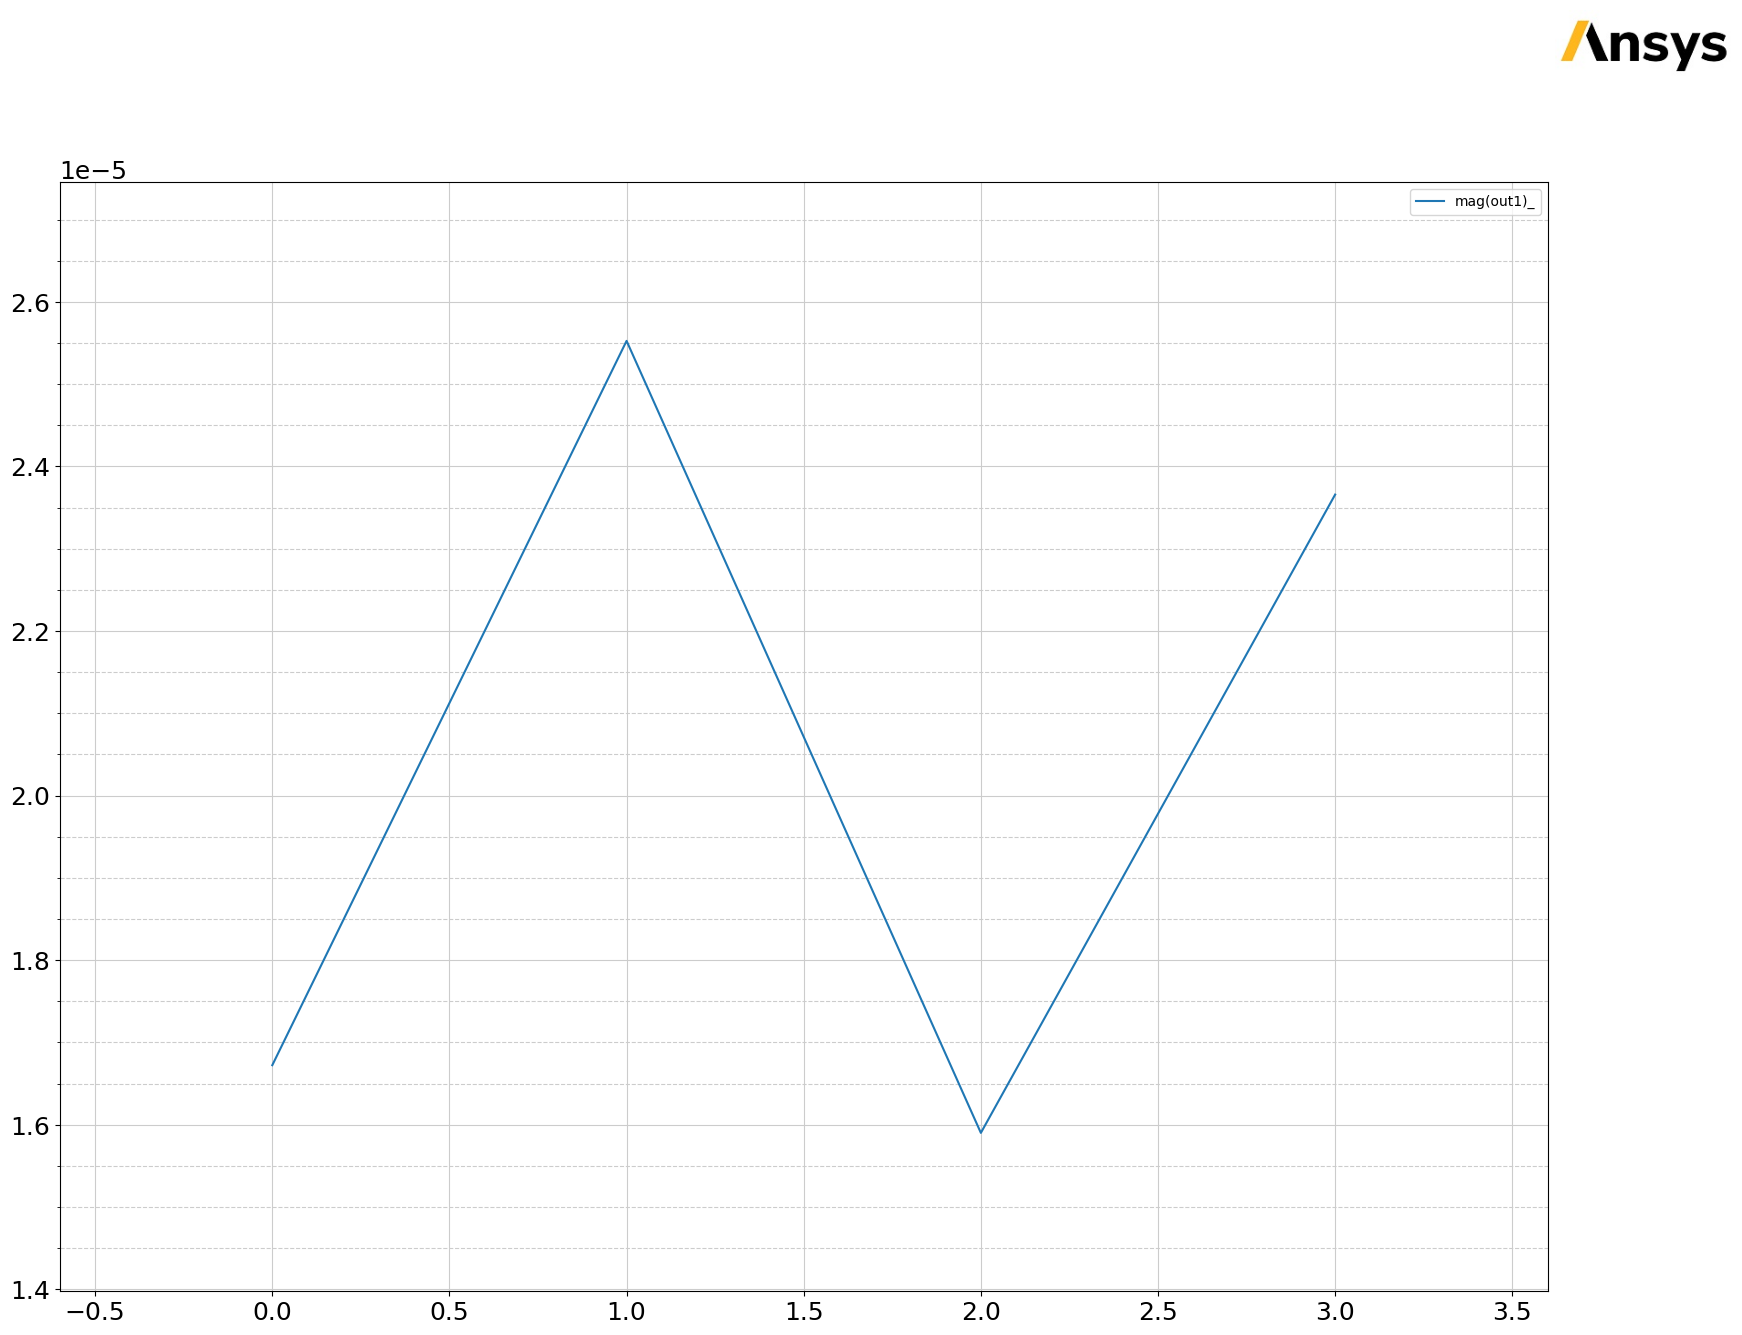

In [16]:
variations = {"MaterialIndex": ["All"], "MaterialThickness": ["Nominal"]}
report = m2d.post.create_report(
    expressions="out1",
    primary_sweep_variable="MaterialIndex",
    report_category="DCConduction",
    plot_type="Data Table",
    variations=variations,
    plot_name="Resistance vs. Material",
)

# ## Get solution data
#
# Get solution data using the ``report``` object to get resistance values
# and plot data outside AEDT.

data = report.get_solution_data()
resistance = data.data_magnitude()
material_index = data.primary_sweep_values
data.primary_sweep = "MaterialIndex"
data.plot(snapshot_path=os.path.join(temp_folder.name, "M2D_DCConduction.jpg"))

# ## Create material index versus resistance table
#
# Create material index versus resistance table to use in the PDF report generator.
# Create ``colors`` table to customize each row of the material index versus resistance table.

material_index_vs_resistance = [["Material", "Resistance"]]
colors = [[(255, 255, 255), (0, 255, 0)]]
for i in range(len(data.primary_sweep_values)):
    material_index_vs_resistance.append(
        [str(data.primary_sweep_values[i]), str(resistance[i])]
    )
    colors.append([None, None])

## Overlay fields

Plot the electric field and current density on the conductor surface.

In [17]:
conductor_surface = m2d.modeler["ANSYS_LOGO_2D_3"].faces
plot1 = m2d.post.create_fieldplot_surface(
    assignment=conductor_surface, quantity="Mag_E", plot_name="Electric Field"
)
plot2 = m2d.post.create_fieldplot_surface(
    assignment=conductor_surface, quantity="Mag_J", plot_name="Current Density"
)

## Overlay fields using PyVista

Plot electric field using PyVista and save to an image file.

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


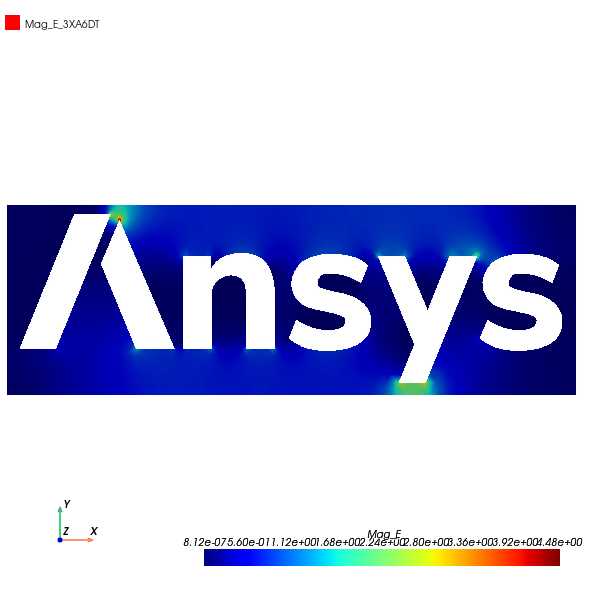

True

In [18]:
py_vista_plot = m2d.post.plot_field(
    quantity="Mag_E", assignment=conductor_surface, plot_cad_objs=False, show=False
)
py_vista_plot.isometric_view = False
py_vista_plot.camera_position = [0, 0, 7]
py_vista_plot.focal_point = [0, 0, 0]
py_vista_plot.roll_angle = 0
py_vista_plot.elevation_angle = 0
py_vista_plot.azimuth_angle = 0
py_vista_plot.plot(os.path.join(temp_folder.name, "mag_E.jpg"))

## Plot field animation

Plot current density verus the material index.

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


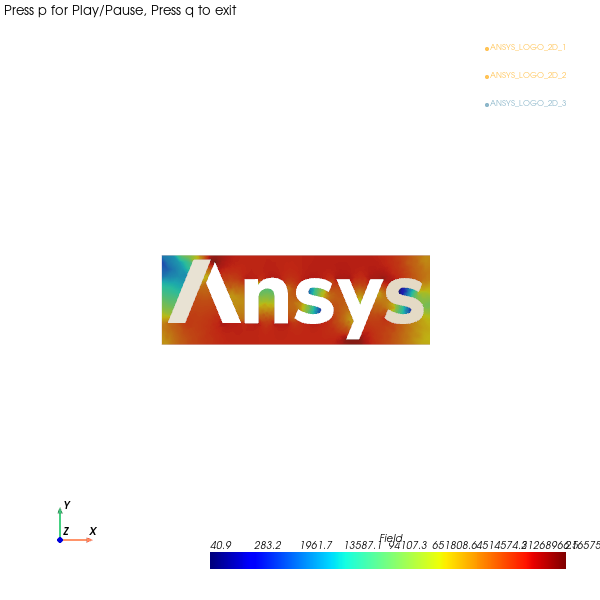

True

In [19]:
animated_plot = m2d.post.plot_animated_field(
    quantity="Mag_J",
    assignment=conductor_surface,
    export_path=temp_folder.name,
    variation_variable="MaterialIndex",
    variations=[0, 1, 2, 3],
    show=False,
    export_gif=False,
    log_scale=True,
)
animated_plot.isometric_view = False
animated_plot.camera_position = [0, 0, 7]
animated_plot.focal_point = [0, 0, 0]
animated_plot.roll_angle = 0
animated_plot.elevation_angle = 0
animated_plot.azimuth_angle = 0
animated_plot.animate()

## Export model picture

In [20]:
model_picture = m2d.post.export_model_picture()

## Generate PDF report

Generate a PDF report with the output of the simulation.

In [21]:
pdf_report = AnsysReport(
    project_name=m2d.project_name, design_name=m2d.design_name, version=AEDT_VERSION
)

Customize the text font.

In [22]:
pdf_report.report_specs.font = "times"
pdf_report.report_specs.text_font_size = 10

Create the report

In [23]:
pdf_report.create()

True

Add project's design information to the report.

PyAEDT WARNING: Argument `export_path` is deprecated for method `plot`; use `output_file` instead.


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


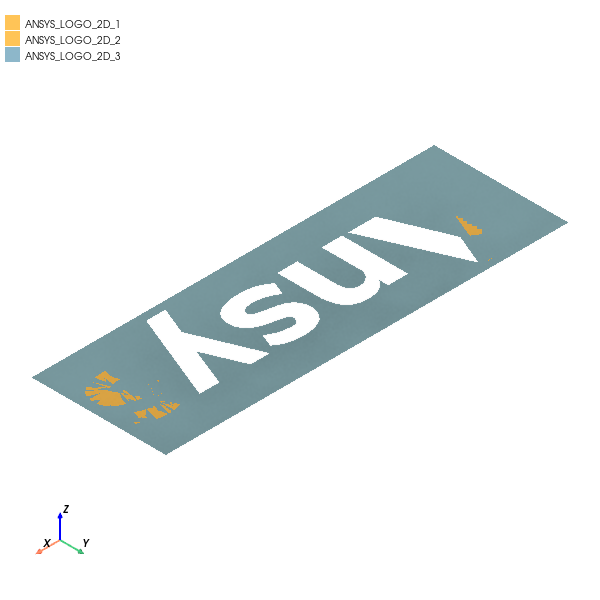

True

In [24]:
pdf_report.add_project_info(m2d)

Add the model picture in a new chapter. Then, add text.

In [25]:
pdf_report.add_chapter("Model Picture")
pdf_report.add_text("This section contains the model picture.")
pdf_report.add_image(path=model_picture, caption="Model Picture", width=80, height=60)

True

Add field overlay plots in a new chapter.

In [26]:
pdf_report.add_chapter("Field overlay")
pdf_report.add_sub_chapter("Plots")
pdf_report.add_text("This section contains the fields overlay.")
pdf_report.add_image(
    os.path.join(temp_folder.name, "mag_E.jpg"), caption="Mag E", width=120, height=80
)
pdf_report.add_page_break()

Add a new section to display results.

In [27]:
pdf_report.add_section()
pdf_report.add_chapter("Results")
pdf_report.add_sub_chapter("Resistance vs. Material")
pdf_report.add_text("This section contains resistance versus material data.")
# Aspect ratio is automatically calculated if only width is provided
pdf_report.add_image(os.path.join(temp_folder.name, "M2D_DCConduction.jpg"), width=130)

True

Add a new subchapter to display resistance data from the previously created table.

In [28]:
pdf_report.add_sub_chapter("Resistance data table")
pdf_report.add_text("This section contains resistance data.")
pdf_report.add_table(
    title="Resistance Data",
    content=material_index_vs_resistance,
    formatting=colors,
    col_widths=[75, 100],
)

Add a table of contents and save the PDF.

In [29]:
pdf_report.add_toc()
pdf_report.save_pdf(temp_folder.name, "AEDT_Results.pdf")

'C:\\Users\\ansys\\AppData\\Local\\Temp\\tmpf5o_db4z.ansys\\AEDT_Results.pdf'

## Release AEDT

In [30]:
m2d.save_project()
m2d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project M2D_DC_Conduction Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [31]:
temp_folder.cleanup()